## Import Packages

In [1]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import defaultdict

## Load Data

In [2]:
# load data

data = pd.read_excel("/content/Study Case DA.xlsx", sheet_name=None)

employees = data['employees']
performance = data['performance_yearly']
competency = data['competencies_yearly']
papi = data['papi_scores']
profiles = data['profiles_psych']
pillars = data['dim_competency_pillars']
strengths = data['strengths']
grades = data['dim_grades']
education = data['dim_education']
tgv_map = data['Talent Variable (TV) & Talent G']

## Descriptive Statistic

This step helps to understand the data that we're dealing with along with the overview of all dataframes.

In [3]:
# descriptive statistics of data

for name,df in data.items():
    print(f"\n==== {name}====")
    print(df.shape)
    print(df.info())
    print(df.columns)
    print(df.head(2))
    print(df.isnull().sum())


==== Talent Variable (TV) & Talent G====
(70, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Test as Talent Variable (TV)  70 non-null     object
 1   Sub-test                      70 non-null     object
 2   Meaning                       67 non-null     object
 3   Behavior Example              67 non-null     object
 4   Talent Group Variable (TGV)   38 non-null     object
 5   Note                          2 non-null      object
dtypes: object(6)
memory usage: 3.4+ KB
None
Index(['Test as Talent Variable (TV)', 'Sub-test', 'Meaning',
       'Behavior Example', 'Talent Group Variable (TGV)', 'Note'],
      dtype='object')
  Test as Talent Variable (TV)             Sub-test  \
0                        Pauli  Initial Performance   
1                         MBTI         Extraversion   

                      

## Step 1 - Discover the Pattern of Success

In [4]:
# make a list for top performers IDs
top_ids = performance[performance['rating']==5]['employee_id'].unique()

# assign this list to all dfs needed
employees['is_top']=employees['employee_id'].isin(top_ids)
competency['is_top']=competency['employee_id'].isin(top_ids)
papi['is_top']=papi['employee_id'].isin(top_ids)
profiles['is_top']=profiles['employee_id'].isin(top_ids)
strengths['is_top']=strengths['employee_id'].isin(top_ids)

### 1.1 Competency Analysis

In [5]:
# start with the competency analysis

# merge pillar label - to make it easier to read
competency = competency.merge(pillars, on='pillar_code', how='left')

# count avg scores per pillar
comp_summary = (
    competency.groupby(['pillar_label', 'is_top'])['score']
    .mean()
    .unstack()
    .sort_values(by=True, ascending=False)
)

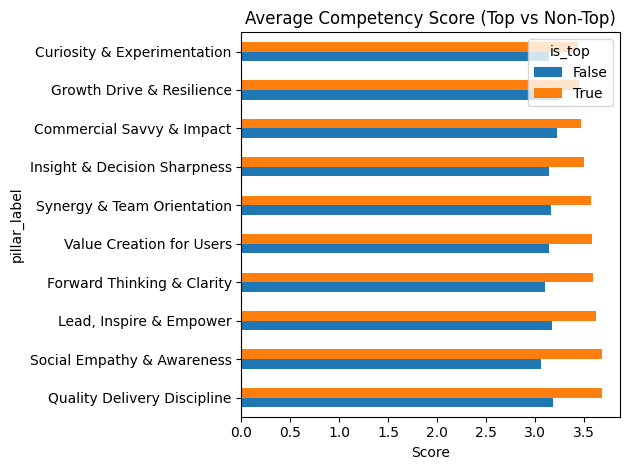

In [6]:
# visualize
comp_summary.plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Average Competency Score (Top vs Non-Top)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

From the plot above, we can see that the top performers consistently have higher average scores in the Competency Pillar. However, to identify which pillar contributes the most to success, we will continue by analyzing the gap between top and non-top performers.

In [7]:
# looking for gap

gap_df = (
    competency.groupby(['pillar_label', 'is_top'])['score']
    .mean()
    .unstack()
    .assign(gap=lambda d: d[True] - d[False])
    .sort_values('gap', ascending=True)
)

In [8]:
gap_df = gap_df.reset_index()

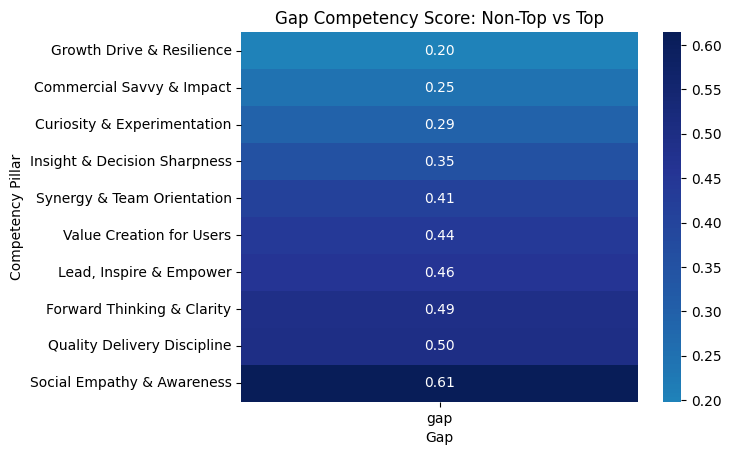

In [9]:
# visualization
gap_only = gap_df.set_index('pillar_label')[['gap']]

sns.heatmap(gap_only, annot=True, cmap='YlGnBu', fmt='.2f', center=0)
plt.title("Gap Competency Score: Non-Top vs Top")
plt.xlabel('Gap')
plt.ylabel('Competency Pillar')
plt.show()

Based on the heatmap, the pillar that shows the most significant difference between top and non-top performers is Social Empathy & Awareness, with a gap of around 0.61. It is followed by Quality Delivery Discipline and Forward Thinking & Clarity. For now, we will keep in mind these three pillars as the ones that may contribute the most to success in the Competency dimension.

### 1.2a Psychometric Analysis - Papi

In [10]:
# continue to papi analysis

# pivot papi from long version to wide version
papi_wide = papi.pivot(index='employee_id', columns='scale_code', values='score').reset_index()

# add top performer flag
papi_wide['is_top']=papi_wide['employee_id'].isin(top_ids)

# show
papi_wide

scale_code,employee_id,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,...,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,is_top
0,DUP1942,6.0,NaN,1.0,4.0,3.0,5.0,4.0,1.0,3.0,...,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,NaN,True
1,DUP2096,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,...,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0,True
2,DUP2722,2.0,NaN,6.0,4.0,1.0,4.0,9.0,9.0,1.0,...,2.0,NaN,6.0,1.0,7.0,3.0,6.0,3.0,3.0,False
3,DUP3015,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,...,1.0,8.0,7.0,3.0,NaN,NaN,3.0,5.0,3.0,True
4,DUP3452,7.0,9.0,1.0,9.0,7.0,3.0,NaN,2.0,1.0,...,NaN,4.0,2.0,9.0,NaN,9.0,1.0,6.0,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,EMP101995,6.0,8.0,6.0,1.0,4.0,8.0,4.0,9.0,7.0,...,4.0,6.0,4.0,1.0,5.0,1.0,8.0,8.0,5.0,False
2006,EMP101996,8.0,4.0,5.0,NaN,5.0,7.0,8.0,7.0,4.0,...,5.0,NaN,3.0,7.0,1.0,2.0,7.0,5.0,2.0,True
2007,EMP101997,9.0,3.0,4.0,6.0,NaN,NaN,5.0,7.0,3.0,...,NaN,5.0,6.0,5.0,NaN,4.0,7.0,4.0,1.0,False
2008,EMP101998,5.0,7.0,1.0,NaN,2.0,5.0,5.0,1.0,2.0,...,NaN,9.0,4.0,4.0,1.0,7.0,9.0,2.0,NaN,True


In [11]:
# take only numeric cols

papi_trait_cols = papi_wide.columns.difference(['employee_id', 'is_top'])

# count avg score per trait per group

papi_mean = papi_wide.groupby('is_top')[papi_trait_cols].mean().T
papi_mean.columns = ['Non-Top', 'Top']
papi_mean['Gap'] = papi_mean['Top'] - papi_mean['Non-Top']
papi_mean = papi_mean.sort_values('Gap', ascending=False)
papi_mean


,Non-Top,Top,Gap
scale_code,,,
Papi_O,4.833189,4.996988,0.163799
Papi_P,4.963956,5.053701,0.089745
Papi_N,5.065476,5.140118,0.074642
Papi_S,4.971649,5.033675,0.062025
Papi_V,4.888041,4.936296,0.048256
Papi_E,5.051089,5.092262,0.041173
Papi_R,5.011915,5.051095,0.039180
Papi_C,4.851727,4.876106,0.024379
Papi_F,5.053985,5.062687,0.008702


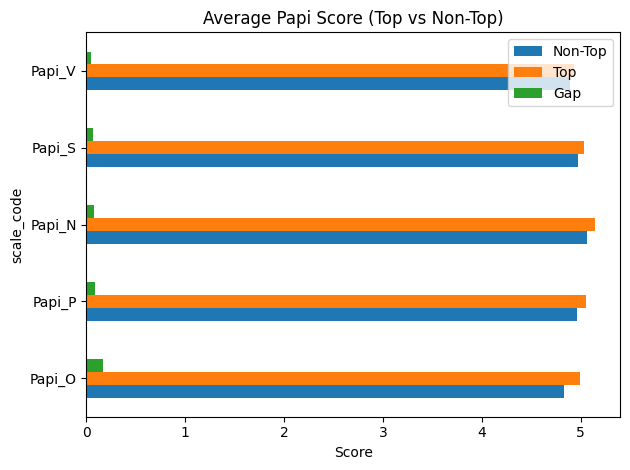

In [12]:
# visualize

papi_mean.head(5).plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Average Papi Score (Top vs Non-Top)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

For the PAPI scores, the gap between top and non-top performers is not very significant. In fact, some traits even show negative values, where non-top performers score higher than top performers. The largest gap is found in PAPI_O (0.16), followed by PAPI_P (0.089) and PAPI_N (0.07). Similar to the competency analysis, we will keep these three traits in mind as they might be important when formulating the success model later.

### 1.2b Psychometric Analysis - Profiles Psych

In [13]:
# continue to psych profiles
# only take numeric columns
cognitive_cols = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki']

psych_df = profiles[['employee_id', 'is_top'] + cognitive_cols]

# count avg score

psych_median = psych_df.groupby('is_top')[cognitive_cols].median().T
psych_median.columns = ['Non-Top', 'Top']
psych_median['Gap'] = psych_median['Top'] - psych_median['Non-Top']
psych_median = psych_median.sort_values('Gap', ascending=False)
psych_median


,Non-Top,Top,Gap
faxtor,61.0,62.0,1.0
tiki,5.0,6.0,1.0
gtq,27.0,28.0,1.0
pauli,60.0,60.0,0.0
iq,109.0,109.0,0.0


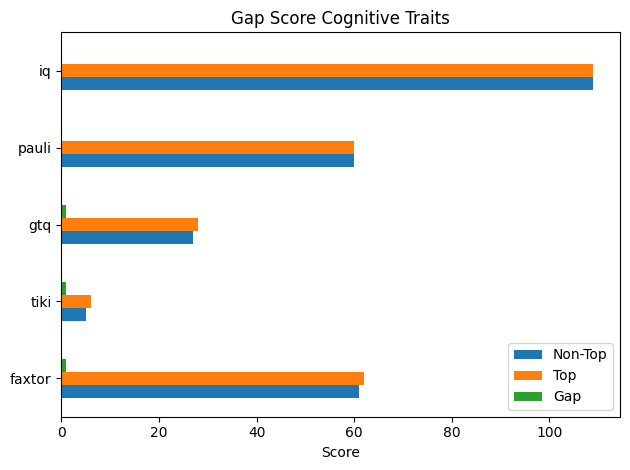

In [14]:
# visualize

psych_median.plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Gap Score Cognitive Traits")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

From the psychological assessments (cognitive part), faxtor, tiqi, and gtq show the largest and also similar gap between top and non-top performers.

### 1.3 Strengths Analysis

In [15]:
# continue to strengths analysis

# only take the 1st rank, but also includes in is_top
top_strengths = strengths[(strengths['rank']==1) & (strengths['is_top'])]
top_strengths['is_match'] = 1

strength_counts = top_strengths['theme'].value_counts().reset_index()
strength_counts.columns = ['Theme', 'Count']

/tmp/ipython-input-727015244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_strengths['is_match'] = 1


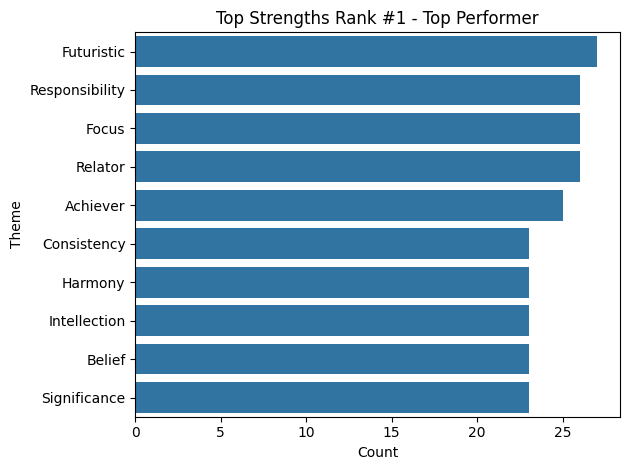

In [16]:
# visualize

plt.figure()
sns.barplot(y='Theme', x ='Count', data=strength_counts.head(10))
plt.title('Top Strengths Rank #1 - Top Performer')
plt.tight_layout()
plt.show()

From the Strengths to Themes mapping, the most frequently appearing theme for Rank 1 and Top performers is Futuristic (27 occurrences). The next three themes, each appearing 26 times, are Responsibility, Focus, and Relator.

### 1.4 Contextual Factors Analysis

In [17]:
# continue to contextual factors analysis

# merge grade and education
emp_context = employees.merge(grades, on='grade_id', how='left').merge(education, on='education_id', how='left')

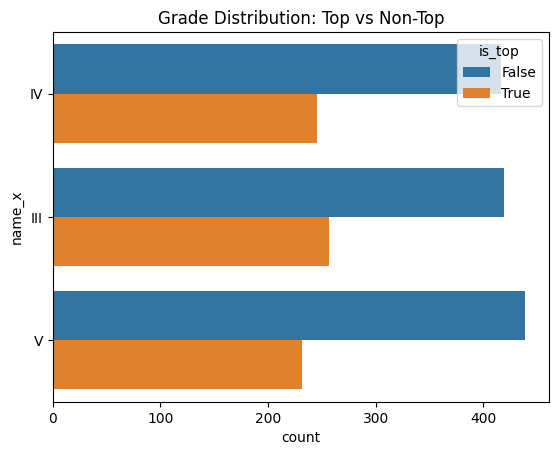

In [18]:
# visualize grade vs is_top

sns.countplot(data=emp_context, y='name_x', hue='is_top')
plt.title('Grade Distribution: Top vs Non-Top')
plt.show()

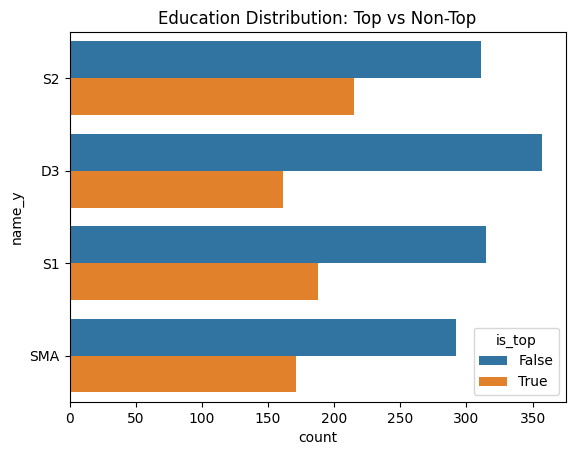

In [19]:
# visualize education vs is_top

sns.countplot(data=emp_context, y='name_y', hue='is_top')
plt.title('Education Distribution: Top vs Non-Top')
plt.show()

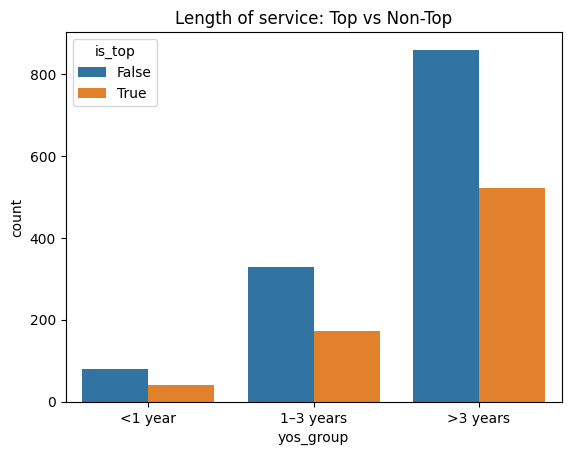

In [20]:
# visualize years or service months vs is_top

emp_context['yos_group'] = pd.cut(emp_context['years_of_service_months'],
                                  bins=[0, 12, 36, 1000],
                                  labels=['<1 year', '1–3 years', '>3 years'])

sns.countplot(data=emp_context, x='yos_group', hue='is_top')
plt.title('Length of service: Top vs Non-Top')
plt.show()

Most top performers come from Grade V, suggesting that senior-level employees are more likely to reach performance level 5. This aligns with the finding that most top performers also have more than 3 years of tenure. On the education side, top performers mostly come from S2 graduates.

### Assigning Talent Variables

Based on the exploration of Competency Analysis, Psychometric Analysis, Strengths Analysis, and Contextual Analysis, several variables were identified as relevant indicators. These variables were derived from the respective summaries of each analysis and can be collectively summarized and mapped as follows:

In [21]:
# summary TV

tv_final = [
    # competency
    'SEA', 'QDD', 'FTC',
    # papi
    'Papi_O', 'Papi_P', 'Papi_N',
    # psych
    'faxtor', 'gtq', 'tiki',
    # strength
    'futuristic', 'responsibility', 'focus', 'relator',
    # contextual
    'grade_name', 'education_level', 'years_of_service_months'
]

## Step 2 - Build Success Formula (Match Score)
### 2.1 Assigning TV to TGV - Structural Mapping

In [22]:
tv_to_tgv = {
    # competency
    'SEA': 'Teamwork',
    'QDD': 'Technical Expertise',
    'FTC': 'Leadership',
    # papi
    'Papi_O': 'Personality',
    'Papi_P': 'Personality',
    'Papi_N': 'Personality',
    # psych
    'faxtor': 'Cognitive Ability',
    'gtq': 'Cognitive Ability',
    'tiki': 'Cognitive Ability',
    # strength
    'futuristic': 'Leadership',
    'responsibility': 'Teamwork',
    'focus': 'Cognitive Ability',
    'relator': 'Teamwork',
    #contextual
    'grade_name': 'Technical Expertise',
    'education_level': 'Technical Expertise',
    'years_of_service_months': 'Leadership'
}

tv_final = list(tv_to_tgv.keys())

- SEA → Teamwork: Represents social empathy and awareness, which foster collaboration, interpersonal understanding, and effective team interaction.
- QDD → Technical Expertise: Highlights consistency, reliability, and discipline in task completion and performance delivery.
- FTC → Leadership: Captures forward thinking and clarity, which are essential for vision-setting, strategic planning, and guiding others.
- Papi_O → Personality: Reflects originality and openness, key components of individual behavioral traits.
- Papi_P → Personality: Indicates assertiveness and proactivity, aligning with core elements of personal disposition.
- Papi_N → Personality: Represents internal motivation and the need for achievement.
- Faxtor → Cognitive Ability: Measures knowledge-comprehension, fluid reasoning, visual processing, and processing speed.
- GTQ → Cognitive Ability: Assesses reasoning and problem-solving capacity.
- Tiki → Cognitive Ability: Evaluates vigilance, accuracy, and sustained mental effort.
- Futuristic → Leadership: Demonstrates vision-oriented thinking, often associated with goal-setting and driving long-term direction.
- Responsibility → Teamwork: Reflects ownership and commitment seriously, key traits to get the team functioning properly
- Focus → Cognitive Ability: Indicates sustained attention and task prioritization, closely tied to mental discipline and executive function.
- Relator → Teamwork: Emphasizes relationship depth and trust-building, critical for cohesive team dynamics.
- grade_name → Technical Expertise: Reflects seniority or job level, implying accumulated workplace exposure and professional maturity.
- education_level → Technical Expertise: Denotes formal education attainment level.
- years_of_service_months → Leadership: Suggests longer tenure, serving as a proxy for familiarity with organizational systems, processes, and roles.

### 2.2 Make a dataframe with all TV values

In [23]:
# prepare data in employees table
employees = employees.merge(grades, on='grade_id', how='left').merge(education, on='education_id', how='left')
employees.rename(columns={'name_x': 'grade_name', 'name_y': 'education_level'}, inplace=True)

In [24]:
employees

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months,is_top,grade_name,education_level
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64,False,IV,S2
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16,False,III,D3
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58,False,III,S2
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15,False,IV,S1
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34,False,III,D3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,DUP1942,Dewi Fadillah Hidayat,325441,4,4,1,4,1,1,2,2,2,79,True,IV,S1
2006,DUP2096,Putri Wibowo,149080,3,3,4,4,2,2,1,3,4,49,True,III,S2
2007,DUP4177,Adi Ginting,116115,4,2,6,4,4,2,3,2,1,75,False,V,S1
2008,DUP9801,Ayu Kusuma Santoso,889823,2,3,3,3,1,3,1,2,4,7,True,III,S1


In [25]:
# merge all key variables into one

tv_df = employees[['employee_id', 'is_top']].copy()

# PAPI from wide format

tv_df = tv_df.merge(papi_wide[['employee_id', 'Papi_O', 'Papi_P', 'Papi_N']], on='employee_id', how='left')

# psychometric

tv_df = tv_df.merge(profiles[['employee_id', 'faxtor', 'gtq', 'tiki']], on='employee_id', how='left')

# strength
strength_ranks = strengths[
    strengths['theme'].isin(['Futuristic', 'Responsibility', 'Focus', 'Relator'])
].pivot(index='employee_id', columns='theme', values='rank').reset_index()

strength_ranks.columns.name = None
strength_ranks.columns = ['employee_id'] + [col.lower() for col in strength_ranks.columns[1:]]

tv_df = tv_df.merge(strength_ranks, on='employee_id', how='left')

# contextual variables

tv_df['grade_name'] = employees['grade_name'].map({'III': 1, 'IV': 2, 'V': 3})
tv_df['education_level'] = employees['education_level'].map({'SMA': 1, 'D3': 2, 'S1': 3, 'S2': 4})
tv_df['years_of_service_months'] = employees['years_of_service_months']

# competency pillars

pivot_comp = competency.pivot_table(index='employee_id', columns='pillar_code', values='score', aggfunc='mean').reset_index()
tv_df = tv_df.merge(pivot_comp[['employee_id', 'SEA', 'QDD', 'FTC']], on='employee_id', how='left')

# as they have strange range (0-6, then suddenly 99), so I need to assign 99 as missing
tv_df[['SEA', 'QDD', 'FTC']] = tv_df[['SEA', 'QDD', 'FTC']].replace(99, np.nan)

tv_df

,employee_id,is_top,Papi_O,Papi_P,Papi_N,faxtor,gtq,tiki,focus,futuristic,relator,responsibility,grade_name,education_level,years_of_service_months,SEA,QDD,FTC
0,EMP100000,False,9.0,3.0,2.0,75,33.0,2,NaN,NaN,NaN,NaN,2,4,64,2.200000,27.000000,2.60
1,EMP100001,False,9.0,5.0,8.0,52,17.0,3,NaN,NaN,12.0,1.0,1,2,16,3.666667,2.666667,3.25
2,EMP100002,False,5.0,3.0,9.0,38,20.0,3,8.0,7.0,NaN,NaN,1,4,58,3.000000,3.250000,2.75
3,EMP100003,False,1.0,8.0,9.0,63,39.0,3,NaN,NaN,NaN,NaN,2,3,15,2.500000,2.250000,2.25
4,EMP100004,False,6.0,7.0,7.0,100,21.0,9,NaN,NaN,13.0,NaN,1,2,34,2.400000,2.600000,3.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,DUP1942,True,3.0,5.0,NaN,54,NaN,8,NaN,NaN,NaN,NaN,2,3,79,2.800000,3.200000,3.00
2006,DUP2096,True,4.0,4.0,1.0,62,NaN,4,NaN,NaN,NaN,NaN,1,4,49,3.600000,3.400000,3.20
2007,DUP4177,False,3.0,3.0,8.0,22,NaN,8,NaN,13.0,14.0,NaN,3,3,75,3.000000,2.500000,3.40
2008,DUP9801,True,7.0,5.0,2.0,64,28.0,7,NaN,7.0,NaN,2.0,1,3,7,3.666667,3.250000,3.25


### 2.3 Normalization

As the talent variables haven't similar range, we need to normalize first.

In [26]:
# define function
def normalize_column(col, min_val, max_val):
    return 100 * (col - min_val) / (max_val - min_val)

# normalization for numeric tv
tv_ranges = {
    'SEA': (0, 6),
    'QDD': (0, 6),
    'FTC': (0, 6),
    'focus': (1, 14),
    'responsibility': (1, 14),
    'relator': (1, 14),
    'futuristic': (1, 14),
    'Papi_O': (1, 9),
    'Papi_P': (1, 9),
    'Papi_N': (1, 9),
    'faxtor': (20, 100),
    'gtq': (9, 46),
    'tiki': (1, 9),
    'grade_name': (1, 3),
    'education_level': (1,4),
    'years_of_service_months': (0, 149)
}
# apply normalization only to defined TVs
for tv, (min_val, max_val) in tv_ranges.items():
    if tv in tv_df.columns:
        tv_df[tv] = normalize_column(tv_df[tv], min_val, max_val)


### 2.4 Make a benchmark dictionary

To define the “success standard”, we calculate the median score of all Talent Variables (TVs) among top performers (`is_top = 1`).  
This benchmark will later be used to compute each employee’s match rate against the success profile.

In [27]:
# make a benchmark dictionary, but exclude non-TV columns
tv_columns_only = [col for col in tv_df.columns if col not in ['employee_id', 'is_top']]
benchmark_dict = (
    tv_df[tv_df['is_top'] == True][tv_columns_only]
    .median(numeric_only=True)
    .to_dict()
)

In [28]:
benchmark_dict

{'Papi_O': 50.0,
 'Papi_P': 50.0,
 'Papi_N': 50.0,
 'faxtor': 52.5,
 'gtq': 51.351351351351354,
 'tiki': 62.5,
 'focus': 46.15384615384615,
 'futuristic': 46.15384615384615,
 'relator': 53.84615384615385,
 'responsibility': 46.15384615384615,
 'grade_name': 50.0,
 'education_level': 66.66666666666667,
 'years_of_service_months': 34.899328859060404,
 'SEA': 56.666666666666664,
 'QDD': 56.666666666666664,
 'FTC': 56.666666666666664}

### 2.5 Calculate Match Score per TV

Match score will range from 0 to 100%.

In [29]:
def calculate_tv_match(row, benchmarks):
    result = {}
    for tv, threshold in benchmarks.items():
        val = row.get(tv, np.nan)
        if pd.notna(val) and pd.notna(threshold) and threshold != 0:
            result[tv] = min(val / threshold, 1.0) * 100  # capped at 100%
        else:
            result[tv] = 0
    return pd.Series(result)

match_scores = tv_df.apply(lambda row: calculate_tv_match(row, benchmark_dict), axis=1)
tv_match = pd.concat([
    tv_df[['employee_id']],
    tv_df[['is_top']],
    match_scores
], axis=1)
tv_match

,employee_id,is_top,Papi_O,Papi_P,Papi_N,faxtor,gtq,tiki,focus,futuristic,relator,responsibility,grade_name,education_level,years_of_service_months,SEA,QDD,FTC
0,EMP100000,False,100.0,50.0,25.0,100.000000,100.000000,20.0,0.0,0.0,0.0,0.000000,100.0,100.0,100.000000,64.705882,100.000000,76.470588
1,EMP100001,False,100.0,100.0,100.0,76.190476,42.105263,40.0,0.0,0.0,100.0,0.000000,0.0,50.0,30.769231,100.000000,78.431373,95.588235
2,EMP100002,False,100.0,50.0,100.0,42.857143,57.894737,40.0,100.0,100.0,0.0,0.000000,0.0,100.0,100.000000,88.235294,95.588235,80.882353
3,EMP100003,False,0.0,100.0,100.0,100.000000,100.000000,40.0,0.0,0.0,0.0,0.000000,100.0,100.0,28.846154,73.529412,66.176471,66.176471
4,EMP100004,False,100.0,100.0,100.0,100.000000,63.157895,100.0,0.0,0.0,100.0,0.000000,0.0,50.0,65.384615,70.588235,76.470588,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,DUP1942,True,50.0,100.0,0.0,80.952381,0.000000,100.0,0.0,0.0,0.0,0.000000,100.0,100.0,100.000000,82.352941,94.117647,88.235294
2006,DUP2096,True,75.0,75.0,0.0,100.000000,0.000000,60.0,0.0,0.0,0.0,0.000000,0.0,100.0,94.230769,100.000000,100.000000,94.117647
2007,DUP4177,False,50.0,50.0,100.0,4.761905,0.000000,100.0,0.0,100.0,100.0,0.000000,100.0,100.0,100.000000,88.235294,73.529412,100.000000
2008,DUP9801,True,100.0,100.0,25.0,100.000000,100.000000,100.0,0.0,100.0,0.0,16.666667,0.0,100.0,13.461538,100.000000,95.588235,95.588235


### 2.6 Aggregate to TGV and Build Success Formula

To preserve gradient performance differences and allow partial credit for near-matches, we scaled each variable's score relative to the benchmark, capping the match at 100%. This ensures the match score reflects not only binary thresholding but the degree of closeness to top performer standards.

In [30]:
tgv_scores = {}

for tgv in set(tv_to_tgv.values()):
    related_tvs = [tv for tv, group in tv_to_tgv.items() if group == tgv]
    match_cols = [tv for tv in related_tvs if tv in tv_match.columns]
    if match_cols:
        tv_match[f'{tgv}_score'] = tv_match[match_cols].mean(axis=1)
        tgv_scores[tgv] = match_cols


From the final result table above, we can see that some candidates with `is_top = True` also have high match scores, these can be considered as actual top performers. However, there are also candidates with `is_top = False` but relatively high match scores. These individuals can be seen as potential top performers, since they have not yet received a top (rating 5) performance score historically, but their other variables indicate strong potential.

In [31]:
tv_match.to_csv("employee_success_score.csv", index=False)

### 2.7 Define TGV Weight & TV Weight

In [32]:
# Calculate gap between top vs non-top
tgv_avg = tv_match.groupby('is_top')[[f'{tgv}_score' for tgv in tgv_scores]].mean().T
tgv_avg.columns = ['non_top', 'top']
tgv_avg['gap'] = tgv_avg['top'] - tgv_avg['non_top']
tgv_avg['weight'] = tgv_avg['gap'] / tgv_avg['gap'].sum()

# Make a dict
tgv_weights = tgv_avg['weight'].to_dict()
tgv_weights

{'Technical Expertise_score': 0.31907528533147345,
 'Teamwork_score': 0.22349819403111906,
 'Leadership_score': 0.3163559958681258,
 'Personality_score': 0.08979822412511423,
 'Cognitive Ability_score': 0.051272300644167504}

***TGV Weight Interpretation***

From the TGV weight calculation, we observe that:

- **Technical Expertise** (32%), **Leadership** (32%), and **Teamwork** (22%) carry the highest weights.

  This suggests that top performers consistently demonstrate superior **executional discipline**, **accountability**, and **collaborative leadership**.

  Specifically, the **Technical Expertise** dimension reflects the ability to apply domain knowledge with consistency, follow through on deliverables, and uphold operational reliability.

  These findings are aligned with research from [Indeed](https://www.indeed.com/career-advice/career-development/high-performers), which highlights that high performers are often distinguished by traits such as **problem-solving ability**, **communication**, **self-direction**, and **adaptability**.

- In contrast, **Personality** (9%) and **Cognitive Ability** (5%) still contribute to performance, but appear more as **supporting traits** rather than primary differentiators.


**Business Implications**

During talent acquisition, development, or promotion decisions, **higher scores in Technical Expertise, Leadership, and Teamwork** should be prioritized, as these traits are most predictive of top performance in the current context.

These insights can also guide targeted learning and development programs:

- Enhance **leadership presence** and ownership
- Strengthen **cross-functional collaboration**
- Reinforce **technical execution reliability**

By focusing on these drivers, organizations can replicate high-performance behaviors more consistently across teams and roles.


In [33]:
# generate tv weight from tgv weight
tgv_tv_count = defaultdict(int)
for tv, tgv in tv_to_tgv.items():
    tgv_tv_count[tgv] += 1

tv_weights = {
    tv: tgv_weights[f'{tgv}_score'] / tgv_tv_count[tgv]
    for tv, tgv in tv_to_tgv.items()
}
tv_weights

{'SEA': 0.07449939801037302,
 'QDD': 0.10635842844382448,
 'FTC': 0.1054519986227086,
 'Papi_O': 0.02993274137503808,
 'Papi_P': 0.02993274137503808,
 'Papi_N': 0.02993274137503808,
 'faxtor': 0.012818075161041876,
 'gtq': 0.012818075161041876,
 'tiki': 0.012818075161041876,
 'futuristic': 0.1054519986227086,
 'responsibility': 0.07449939801037302,
 'focus': 0.012818075161041876,
 'relator': 0.07449939801037302,
 'grade_name': 0.10635842844382448,
 'education_level': 0.10635842844382448,
 'years_of_service_months': 0.1054519986227086}

**TV Weight Interpretation**

The `tv_weights` were derived by proportionally distributing each Talent Group Variable (TGV) weight across its component Talent Variables (TVs), resulting in a granular and interpretable final score.

This ensures that:
- The final match score reflects both **high-level success domains** (e.g., Leadership, Technical Expertise) and
- The **specific traits or signals** that operationalize those domains at the individual level


**Summary**

- The **most influential variables** contributing to the match score are:
  - `grade_name`, `education_level`, `QDD` (Technical Expertise)
  - `FTC`, `futuristic`, `years_of_service_months` (Leadership)

- Lower weights on variables like `faxtor`, `tiki`, and `Papi_O` reflect that while still relevan, these traits were **less differentiating** between top and non-top performers.

This structure allows hiring managers and HR partners to:
- Prioritize candidates who excel in **domain mastery**, **strategic leadership**, and **collaborative execution**
- Maintain transparency and explainability in the talent selection process

In [34]:
# re-calculate tgv score using tv weight
for tgv in tgv_scores:
    cols = tgv_scores[tgv]
    weights = [tv_weights[tv] for tv in cols]
    tv_match[f'{tgv}_score'] = (tv_match[cols] * weights).sum(axis=1) / sum(weights)

### 2.8 Final Match Score using TGV Weight

In [35]:
tgv_cols = [f'{tgv}_score' for tgv in tgv_scores.keys()]
final_weights = [tgv_weights[tgv_col] for tgv_col in tgv_cols]

tv_match['final_match_score'] = (tv_match[tgv_cols] * final_weights).sum(axis=1) / sum(final_weights)

# final result
final_result = tv_match[['employee_id', 'final_match_score']].sort_values(by='final_match_score', ascending=False)
final_result.head(10)


,employee_id,final_match_score
1315,EMP101315,95.099281
505,EMP100505,92.960160
1424,EMP101424,92.532087
171,EMP100171,92.184361
768,EMP100768,90.493680
1265,EMP101265,90.226276
298,EMP100298,89.770235
1173,EMP101173,88.739614
530,EMP100530,88.725404
1950,EMP101950,88.437649


## Step 3 - Preparing for the SQL

In [36]:
with open("tgv_weights.json", "w") as f:
    json.dump(tgv_weights, f, indent=2)

with open("tv_weights.json", "w") as f:
    json.dump(tv_weights, f, indent=2)

with open("benchmark_dict.json", "w") as f:
    json.dump(benchmark_dict, f, indent=2)

with open("tv_to_tgv.json", "w") as f:
    json.dump(tv_to_tgv, f, indent=2)

In [ ]:
# saving CSV for table_benchmarks
sheets = ["employees", "dim_grades", "dim_positions", "dim_directorates"]

for sheet in sheets:
    df = pd.read_excel("/content/Study Case DA.xlsx", sheet_name=sheet)
    df.to_csv(f"{sheet}.csv", index=False)
    print(f"✅ Saved {sheet}.csv")

✅ Saved employees.csv
✅ Saved dim_grades.csv
